## Dali custom operators

Tested with python 3.8

In [1]:
import nvidia.dali.plugin_manager as plugin_manager
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

In [2]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from timeit import default_timer as timer

In [4]:
plugin_manager.load_library('/home/ice/CLionProjects/CustomOp/cmake-build-debug/libCustomOp.so')

In [5]:
class TestPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(TestPipeline, self).__init__(batch_size, num_threads, device_id)
        self.input = ops.SegFileReader(file_root='data', file_list='/home/ice/CLionProjects/CustomOp/data/file_list.txt', random_shuffle = True)
        self.decodeMulti = ops.TiffDecoder(device="cpu")
        self.rotate = ops.Rotate(device='gpu', interp_type=types.INTERP_NN, keep_size=True) 
        self.rotate_range = ops.Uniform(range = (-27, 27))
        self.rotate_coin = ops.CoinFlip(probability=0.5)
        self.transpose = ops.Transpose(perm=[1, 2, 0])
        self.transposeBack = ops.Transpose(device='gpu', perm=[2, 0, 1])
        

    def define_graph(self):
        angle_range = self.rotate_range()
        prob_rotate = self.rotate_coin()
        image, mask = self.input()
        
        image = self.decodeMulti(image)
        mask = self.decodeMulti(mask)

        image = self.transpose(image)
        image = self.rotate(image.gpu(), angle=angle_range)
        image = self.transposeBack(image)
        
        mask = self.transpose(mask)
        mask = self.rotate(mask.gpu(), angle=angle_range)
        mask = self.transposeBack(mask)
        
        return image, mask

In [6]:
def show_images(image_batch):
    columns = 4
    rows = 2
    fig = plt.figure(figsize=(20,10))   
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(0)[j,:,:], cmap='gray')

In [7]:
def speedtest(pipeclass, batch, n_threads):
    pipe = pipeclass(batch, n_threads, 0)
    pipe.build()
    
    # warmup
    for i in range(5):
        pipe.run()
    
    # test
    for j in range(20):
        n_test = 20
        t_start = timer()
        for i in range(n_test):
            pipe.run()
        t = timer() - t_start
        print("Speed: {} imgs/s".format((2 * n_test * batch)/t)) # we double count as labels are images as well

In [8]:
test_batch_size = 20
speedtest(TestPipeline, test_batch_size, 8)

Speed: 1611.8087459243077 imgs/s
Speed: 1562.0867273788922 imgs/s
Speed: 1565.539629730331 imgs/s
Speed: 1587.5288779675857 imgs/s
Speed: 1594.4750768931242 imgs/s
Speed: 1577.6339248652062 imgs/s
Speed: 1532.0731557994563 imgs/s
Speed: 1559.13953358636 imgs/s
Speed: 1548.1171121371904 imgs/s
Speed: 1574.9319157868067 imgs/s
Speed: 1521.7424873642315 imgs/s
Speed: 1582.6118874994895 imgs/s
Speed: 1555.8526408653245 imgs/s
Speed: 1527.6526731073373 imgs/s
Speed: 1499.1321664355764 imgs/s
Speed: 1551.308927089134 imgs/s
Speed: 1514.9132892989405 imgs/s
Speed: 1600.8694930510958 imgs/s
Speed: 1511.900768142289 imgs/s
Speed: 1578.5584126656922 imgs/s


In [9]:
bs = 8
pipe = TestPipeline(batch_size=bs, num_threads=4, device_id=0)
pipe.build()
pipe_out = pipe.run()

In [10]:
images, labels = pipe_out
print("Images is_dense_tensor: " + str(images.is_dense_tensor()))
print("Labels is_dense_tensor: " + str(labels.is_dense_tensor()))
labels.at(0).shape()

Images is_dense_tensor: True
Labels is_dense_tensor: True


[16, 256, 256]

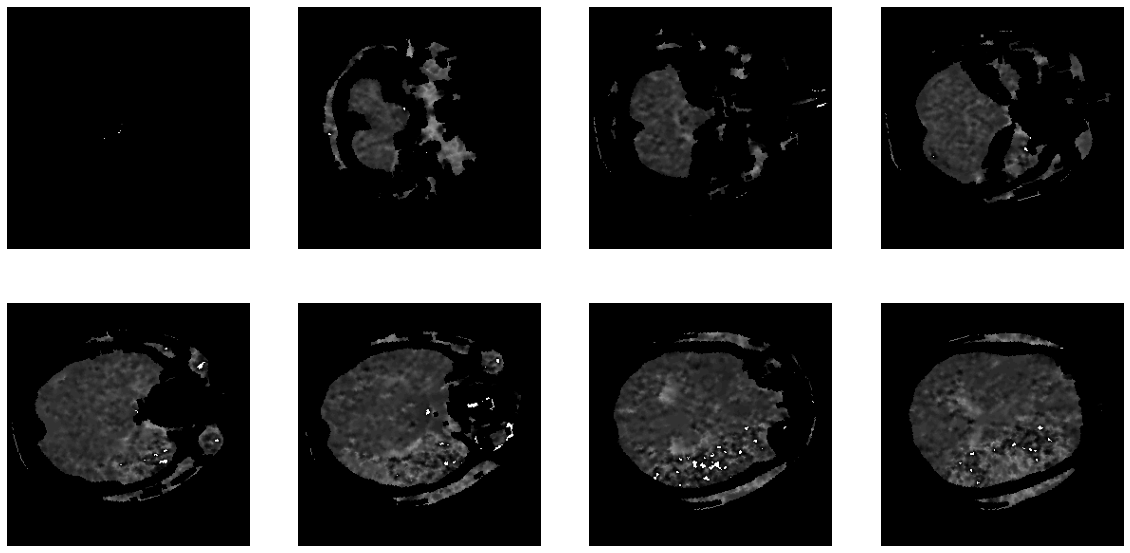

In [11]:
show_images(images.as_cpu())